# Python for HPC

## Max Planck Computing and Data Facility, Garching

## NumPy exercises
* a leading `#?` is used to indicate that you should add a line of code
* a trailing `#$` is used to indicate solution lines (to support automated stripping)

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Replace loops by operations on arrays

### Derivatives with finite differences
Given the values of a function $f_i$ at equidistant points $x_i$ (grid spacing $h$), the second derivative can be computed as
$$ f_i'' \approx \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2} $$

Mean difference:  0.00021340459938643913


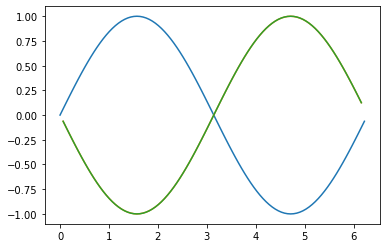

In [16]:
# some definitions, take sin as an example function
N = 10**2
h = 2.*np.pi/N
x = np.arange(N) * h
# example function:
f = np.sin(x)
# analytic solution for second derivative: d(sin) = cos, d(cos) = - sin -> d(d(sin)) = -sin
fdd_analytic = -f[1:-1]

def second_derivative_fd(left, center, right, h):
    return (left - 2.*center + right)/h**2

def get_second_derivative_v1(f, h):
    fdd = []
    for i in range(1, len(f)-1):
        fdd.append(second_derivative_fd(f[i-1], f[i], f[i+1], h))
    return fdd

fdd_v1 = get_second_derivative_v1(f, h)
print("Mean difference: ", np.mean(np.abs(fdd_v1 - fdd_analytic)))
plt.plot(x, f)
plt.plot(x[1:-1], fdd_v1)
plt.plot(x[1:-1], fdd_analytic)

In [17]:
# Get some timings for different N
def compute_fdd(method, N):
    h = 2.*np.pi/N
    x = np.arange(N) * h
    f = np.sin(x)
    fdd = method(f, h)
    # remove the boundary from the analytic solution
    n_boundary = (N - len(fdd)) // 2
    fdd_analytic = -f[n_boundary:-n_boundary]
    return {'x': x[n_boundary:-n_boundary], 'h': h,
            'fdd': fdd, 'fdd_analytic': fdd_analytic}

# get timing
%timeit compute_fdd(get_second_derivative_v1, 10**5)
# check error of result
result = compute_fdd(get_second_derivative_v1, 10**5)
print("Mean difference: ", np.mean(np.abs(result['fdd'] - result['fdd_analytic'])))

88.3 ms ± 900 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean difference:  5.8911414080910735e-08


Let's make it faster!

81.6 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean difference:  5.8911414080910735e-08


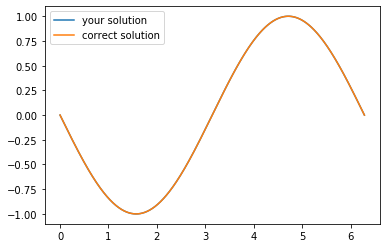

In [18]:
# for version 2, define a result array of the correct size and do everything in one loop (no extra function)
def get_second_derivative_v2(f, h):
    fdd = np.zeros(len(f)-2)   #$
    for i in range(1, len(f)-1):   #$
        fdd[i-1] = (f[i-1]-2.*f[i]+f[i+1])/h**2   #$
    return fdd

# get timing -> compare to version 1
%timeit compute_fdd(get_second_derivative_v2, 10**5)
# check error of result
result = compute_fdd(get_second_derivative_v2, 10**5)
print("Mean difference: ", np.mean(np.abs(result['fdd'] - result['fdd_analytic'])))
plt.plot(result['x'], result['fdd'], label='your solution')
plt.plot(result['x'], result['fdd_analytic'], label='correct solution')
plt.legend()

1.35 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Mean difference:  5.8911414080910735e-08


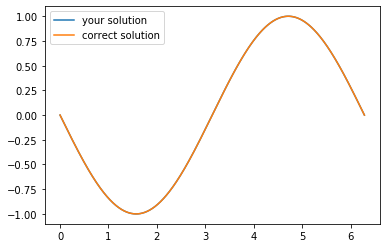

In [19]:
# for version 3, turn the loop into operations on arrays
# index substitutions: i -> 1:N-1, i-1 -> 0:N-2, i+1 -> 2:N
def get_second_derivative_v3(f, h):
    N = len(f)   #$
    fdd = (f[0:N-2] - 2.* f[1:N-1]  + f[2:N])/h**2   #$
    return fdd

# get timing -> compare to version 1
%timeit compute_fdd(get_second_derivative_v3, 10**5)
# check error of result
result = compute_fdd(get_second_derivative_v3, 10**5)
print("Mean difference: ", np.mean(np.abs(result['fdd'] - result['fdd_analytic'])))
plt.plot(result['x'], result['fdd'], label='your solution')
plt.plot(result['x'], result['fdd_analytic'], label='correct solution')
plt.legend()

## Linear algebra

### Matrix multiplication

Multiplying a matrix $A$ with elements $a_{ij}$ with a vector $v$ with elements $v_j$ can be written in components as (row times column!)
$$w_i = \sum_j a_{ij} v_j,\quad \text{for every }i$$.

Multiplying a matrix $A$ with a matrix $B$ can be written as
$$c_{ij} = \sum_k a_{ik} b_{kj},\quad \text{for every }i, j$$

Let's implement this with loops and compare to the numpy functions.

In [32]:
# matrix-vector multiplication
N = 10**3
# define a random matrix (N,N) and vector (N)
A = np.random.rand(N, N)
v = np.random.rand(N)

# define a function for the multiplication
def matrix_vector_multiplication(A, v):
    # define the result vector
    w = np.zeros(A.shape[0])
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            # compute w[i]
            w[i] += A[i, j] * v[j]   #$
    return w
    
# compare timing to numpy function dot
%timeit matrix_vector_multiplication(A, v)
%timeit np.dot(A, v)

567 ms ± 8.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
120 µs ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [33]:
# matrix-matrix multiplication
N = 10**2
# define two random matrices (N,N)
A = np.random.rand(N, N)
B = np.random.rand(N, N)

# define a function for the multiplication
def matrix_matrix_multiplication(A, B):
    # define the result matrix
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                # compute C[i, j]
                C[i, j] += A[i, k] * B[k, j]   #$
    return C
    
# compare timing to numpy function dot
%timeit matrix_matrix_multiplication(A, B)
%timeit np.dot(A, B)

# verify result
print("Results the same:", np.allclose(np.dot(A, B), matrix_matrix_multiplication(A, B)))

665 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.1 µs ± 919 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Results the same: True


**Why are the numpy results so much better?**

Numpy uses highly optimized routines from a BLAS implementation (basic linear algebra subsystem), e.g. from Intel MKL (math kernel library). These exploit the caches in an optimal way to avoid loading too much values from memory (which is extremely slow compared to the caches).

$\to$ use these optimized routines as much as possible!

### Eigenvalues and eigenvectors of the Pauli matrices

We would like to compute eigenvalues and eigenvalues of the Pauli matrices using numpy functions.

Eigenvectors $v$ and eigenvalues $\lambda$ of a matrix $A$ fulfill the equation
$$A v = \lambda v$$

The Pauli matrices are heavily used in quantum mechanics to represent spin operators. They are complex, hermitian matrices given by
$$
\sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, \ 
\sigma_y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, \ 
\sigma_z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}.
$$

In [34]:
# define the Pauli matrices
sigma_x = np.array([[0, 1],[1, 0]], dtype=np.complex128)
sigma_y = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
sigma_z = np.array([[1, 0],[0, -1]], dtype=np.complex128)

# do a matrix product with a vector
v = np.array([1, 2])
w = np.dot(sigma_x, v)
print(w)

# let's solve the eigenproblem (use LA.eig)
import numpy.linalg as LA
# eigenvalues eigenvectors = ...
eigenvalues, eigenvectors = LA.eig(sigma_x)   #$
# print the eigenvalues and eigenvectors
print(eigenvalues)   #$
print(eigenvectors)   #$
# verify the solution:
# for each eigenvalue and eigenvector, compute sigma_x*eigenvector - eigenvalue * eigenvector; this must be zero
for i in range(len(eigenvalues)):   #$
    residual = np.dot(sigma_x, eigenvectors[i, :]) - eigenvalues[i] * eigenvectors[i, :]   #$
    print("Is an eigenvector: ", np.allclose(residual, 0.0))   #$

[2.+0.j 1.+0.j]
[ 1.+0.j -1.+0.j]
[[ 0.70710678-0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
Is an eigenvector:  True
Is an eigenvector:  True


Next steps:
* Solve the eigenvalue problems for the other Pauli matrices
* Verify that the solution is correct
* Solve an eigenvalue problem for a large random matrix (e.g. $10^2 \times 10^2$) and verify the solution

## Fast fourier transformations (FFT)

* Can be used to compute Fourier transformations of discrete data
* Fourier transformation useful for
    * Computing spectra
    * Computing convolutions (also for solving some differential equations)
* Examples:
    * 1D FFT: Compute a spectrum of a signal
    * 2D FFT: Autocorrelation function of an image

### 1D FFT: compute a spectrum of a signal
1. create a sum of sine signals with different frequencies and plot it
2. compute FFT and plot spectrum

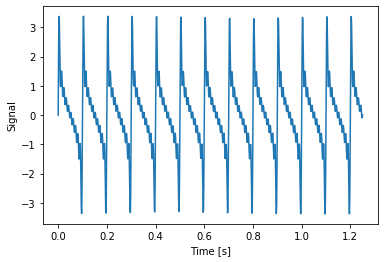

In [35]:
import matplotlib.pyplot as plt
N = 1000               # number of sample points
delta_t = 1.0 / 800.0  # sample spacing in seconds (inverse of rate)

# generate times
times = np.linspace(0.0, N*delta_t, N)
# now the signal as a sum of different contributions
signal = np.zeros_like(times)
for k in range(1, 11):
    signal += np.sin(10*k * 2.0*np.pi*times) / np.sqrt(k) # try out different forms here

plt.plot(times, signal)
plt.xlabel("Time [s]")
a = plt.ylabel("Signal")

In [36]:
# play the signal as audio
import IPython
IPython.display.Audio(data=signal, rate=1/delta_t)

Signal is the same:  True


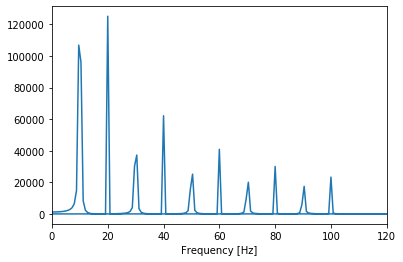

In [37]:
# compute the Fourier transform of the signal
# spectrum =
spectrum = np.fft.fft(signal)   #$
# get the corresponding frequencies
# frequencies =
frequencies = np.fft.fftfreq(N, delta_t)   #$
# compute the inverse FFT, should give the signal back
# signal_forth_back =
signal_forth_back = np.fft.ifft(spectrum)   #$
print("Signal is the same: ", np.allclose(signal, signal_forth_back))

plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(np.abs(spectrum)**2))
plt.xlim(0, 120)
a=plt.xlabel('Frequency [Hz]')

Next steps:
* Use more or less contributions in the sum
* Change the form of the signal (division by a different factor, ...)
* Modify the spectrum and transform it back; listen to the new signal and see how it changed

### Analyzing real audio data
1. Read .wav files
2. Compute and plot spectrum
3. Compare two different samples

In [38]:
import IPython
IPython.display.Audio("Kawai-K5000W-Fret-Noise.wav")

In [39]:
from scipy.io import wavfile
filename = "Kawai-K5000W-Fret-Noise.wav"
# read in the wav file
rate, data = wavfile.read(filename)
# rate is the smapling rate in Hz, data is a 2D array with amplitude for left and right channels
print(data.shape)
N = data.shape[0]
time = np.arange(N) / rate
left_signal = data[:, 0]
right_signal = data[:, 1]

(47262, 2)


/home/sohlmann/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  after removing the cwd from sys.path.


**Next steps:**
* Listen to the signal
* Plot left and right signal
* Zoom in on the signal (e.g. plt.xlim(0.15, 0.16), try out different limits) to explore its shape
* Compute and plot spectrum (you might want to use plt.xlim(0, 4e3) to limit the spectrum to about 4 kHz)
* Do the same for the file "Casio-CZ-5000-Synth-Bass-C1.wav"
* Some questions to answer:
    * What differences do you notice while listening?
    * Is the signal higher/lower? What do you expect for the spectrum of the second signal compared to the first?
    * Can you explain the differences in the spectrum?

In [60]:
from scipy.io import wavfile
def plot_signal_and_spectrum(filename, upper_limit=4e3):
    rate, data = wavfile.read(filename)
    N = data.shape[0]
    time = np.arange(N) / rate

    # freq =
    # left =
    # right =
    freq = np.fft.fftfreq(N, 1/rate)   #$
    left = np.fft.fft(data[:, 0])   #$
    right = np.fft.fft(data[:, 1])   #$

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(time, data[:,0], label='left')
    plt.plot(time, data[:,1], label='right')
    plt.xlabel('Time [s]')
    #plt.xlim(0.1, 0.2)
    #plt.xlim(0.13, 0.16)
    #plt.xlim(0.15, 0.16)
    plt.legend()
    plt.subplot(122)
    plt.plot(freq, np.abs(left)**2, label='left')
    plt.plot(freq, np.abs(right)**2, label='right')
    plt.xlim(0, upper_limit)
    plt.xlabel('Frequency [Hz]')
    plt.legend()

In [58]:
import IPython
IPython.display.Audio("Kawai-K5000W-Fret-Noise.wav")

/home/sohlmann/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


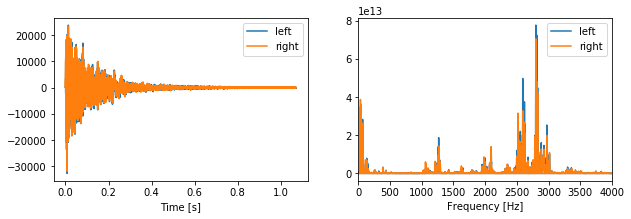

In [61]:
plot_signal_and_spectrum("Kawai-K5000W-Fret-Noise.wav", 4e3)

In [43]:
import IPython
IPython.display.Audio("Casio-CZ-5000-Synth-Bass-C1.wav")

/home/sohlmann/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sohlmann/anaconda/3/2020.02/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


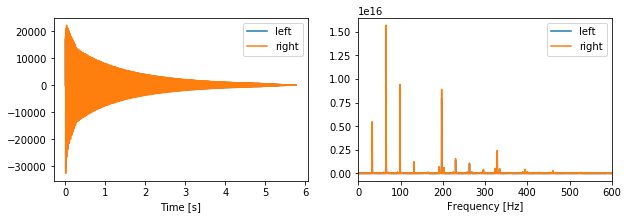

In [44]:
plot_signal_and_spectrum("Casio-CZ-5000-Synth-Bass-C1.wav", 600)

Now we would like to modify the signal.

Damp the left and the right signal in Fourier space by a factor of 10 for frequencies larger than 500 (you need to take the absolute value of the frequencies!). Then transform it back to real space and plot the signal and listen to it.

How is it different? How does it sound?

Feel free to play with the frequency above which you damp and with the damping factor.

/home/sohlmann/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  
/home/sohlmann/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/home/sohlmann/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


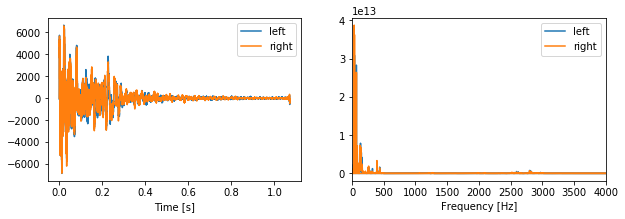

In [87]:
filename = "Kawai-K5000W-Fret-Noise.wav"
rate, data = wavfile.read(filename)
N = data.shape[0]
time = np.arange(N) / rate

# get the fourier transform
freq = np.fft.fftfreq(N, 1/rate)   #$
left = np.fft.fft(data[:, 0])   #$
right = np.fft.fft(data[:, 1])   #$
# damp the high frequencies
left[np.abs(freq) > 5e2] /= 10    #$
right[np.abs(freq) > 5e2] /= 10    #$
# transform back
damped = np.zeros_like(data)    #$
damped[:, 0] = np.fft.ifft(left).astype(np.int16)    #$
damped[:, 1] = np.fft.ifft(right).astype(np.int16)    #$

# now plot the transformed data
upper_limit = 4e3
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(time, damped[:,0], label='left')
plt.plot(time, damped[:,1], label='right')
plt.xlabel('Time [s]')
#plt.xlim(0.1, 0.2)
#plt.xlim(0.13, 0.16)
#plt.xlim(0.15, 0.16)
plt.legend()
plt.subplot(122)
plt.plot(freq, np.abs(left)**2, label='left')
plt.plot(freq, np.abs(right)**2, label='right')
plt.xlim(0, upper_limit)
plt.xlabel('Frequency [Hz]')
plt.legend()
# listen to the transformed data
import IPython
IPython.display.Audio(damped.T, rate=rate)

## More exercises
A collection of 100 Numpy exercies can be found at https://github.com/rougier/numpy-100

## Additional material

### Convergence of finite-difference approximations

Let's use a higher order formula to get a smaller error:
$$ f_i'' \approx \frac{-f_{i-2} + 16f_{i-1} - 30f_i + 16f_{i+1} -f_{i+2}}{12h^2}$$

1.54 ms ± 61.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Mean difference:  7.872135028296314e-08


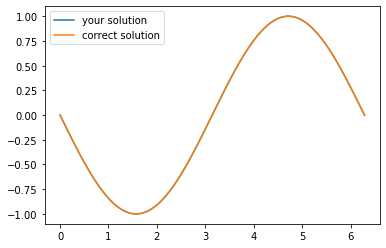

In [20]:
# for version 4, implement the higher order formula with array operations
def get_second_derivative_v4(f, h):
    N = len(f)   #$
    fdd = (-f[0:N-4] + 16*f[1:N-3] - 30.* f[2:N-2]  + 16*f[3:N-1] - f[4:N])/(12*h**2)   #$
    return fdd

# get timing -> compare to version 1
%timeit compute_fdd(get_second_derivative_v4, 10**5)
# check error of result
result = compute_fdd(get_second_derivative_v4, 10**5)
print("Mean difference: ", np.mean(np.abs(result['fdd'] - result['fdd_analytic'])))
plt.plot(result['x'], result['fdd'], label='your solution')
plt.plot(result['x'], result['fdd_analytic'], label='correct solution')
plt.legend()

Mean difference:  0.022596581128034574


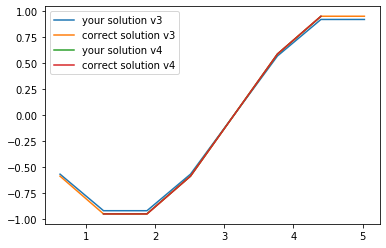

In [21]:
# compare version 3 and 4 for coarse resolution -> 4 should be better!
N = 10**1
result = compute_fdd(get_second_derivative_v3, N)
result2 = compute_fdd(get_second_derivative_v4, N)
print("Mean difference: ", np.mean(np.abs(result['fdd'] - result['fdd_analytic'])))
plt.plot(result['x'], result['fdd'], label='your solution v3')
plt.plot(result['x'], result['fdd_analytic'], label='correct solution v3')
plt.plot(result2['x'], result2['fdd'], label='your solution v4')
plt.plot(result2['x'], result2['fdd_analytic'], label='correct solution v4')
plt.legend()

#### Further things to try:
* Try the same for other functions, e.g. cos, exp, polynomials ($x^2$, $x^5-2x^2+5$, ...), ... (don't forget to compute the analytic solution to compare with!)
* Compare timings for different input sizes N, make a plot, what is the dependence? What would you expect?

The finite-difference expressions shown above are only approximations of the true derivatives. The error to the true derivative depends on the grid spacing $h$,
$$ f_i'' = \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2} + O(h^2),$$
where the last term basically means "something at most proportional to $h^2$".

If we want study the *convergence* of such an expression, we usually compute errors of the expression compared to a known solution for different grid spacings $h$ and analyze the dependence on $h$. Usually, it is some kind of power law proportional to $h^n$, where $n$ is then call order of convergence.

But how do we compute errors on these equidistant grids we used? This is usually accomplished with integral norms, most often $L^1$ or $L^2$ norms (more generally $L^p$ norms). The norms are defined as follows:
$$L^1: \quad |f|_1 = \int |f(x)| dx$$
$$L^2: \quad |f|_2 = \left(\int |f(x)|^2 dx \right)^{1/2}$$
$$L^p: \quad |f|_p = \left(\int |f(x)|^p dx \right)^{1/p}$$

This exercise now has two parts:
1. Compute errors with norms
2. Scaling of error with $h$ (i.e. convergence behavior)
3. Comparison of convergence behavior of different expressions

#### 1. Compute error with norms
To compute the norms as given above, we have to discretize the integrals, i.e. write them in such a way that we can use the discrete values of our function $f_i$. The easiest way is to write the integrals as *Riemann sums*:
$$|f|_1 = \int |f(x)| dx \approx \sum_0^N |f_i| \Delta x = \sum_0^N |f_i| h$$
$$|f|_2 = \left(\int |f(x)|^2 dx \right)^{1/2} \approx \left(\sum_0^N |f_i|^2 h \right)^{1/2}$$
$$|f|_p = \left(\int |f(x)|^p dx \right)^{1/p} \approx \left(\sum_0^N |f_i|^p h \right)^{1/p}$$

Let's first do a naive implementation and then improve it by working on arrays.

In [22]:
# l1 norm with loop
def norm_l1_loop(f, h):
    result = 0
    for i in range(len(f)):
        result += np.abs(f[i]) * h
    return result

# l2 norm with loop
def norm_l2_loop(f, h):
    result = 0
    for i in range(len(f)):   #$
        result += f[i]**2 * h   #$
    result = np.sqrt(result)   #$
    return result

# now transform loops to use numpy functions on the full array
# l1 norm on arrays
def norm_l1(f, h):
    result = np.sum(np.abs(f)) * h   #$
    return result

# l2 norm on arrays
def norm_l2(f, h):
    result = np.sqrt(np.sum(f**2) * h)   #$
    return result

# compare timings
result = compute_fdd(get_second_derivative_v3, 10**3)
%timeit norm_l1_loop(result['fdd'], result['h'])
%timeit norm_l2_loop(result['fdd'], result['h'])
%timeit norm_l1(result['fdd'], result['h'])
%timeit norm_l2(result['fdd'], result['h'])

1.31 ms ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
587 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.38 µs ± 156 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
7.63 µs ± 322 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Additional exercise: write a function to compute the $L^p$ norm and compare the timing to the other functions.

Now compare the $L^1$ and $L^2$ norms of the difference of the computed and true solutions for two different numbers of points (100 and 10000). What do you expect for the larger number of points? Should the norms be smaller or larger?

In [23]:
def get_norms_of_difference(method, N):
    result = compute_fdd(method, N)
    # l1 = norm_l1(...)
    l1 = norm_l1(result['fdd'] - result['fdd_analytic'], result['h'])   #$
    l2 = norm_l2(result['fdd'] - result['fdd_analytic'], result['h'])   #$
    return {'l1': l1, 'l2': l2, 'h': result['h']}

print("Norms for N=10**2: ", get_norms_of_difference(get_second_derivative_v3, 10**2))
print("Norms for N=10**4: ", get_norms_of_difference(get_second_derivative_v3, 10**4))

Norms for N=10**2:  {'l1': 0.0013140434304824318, 'l2': 0.0005830142273782294, 'h': 0.06283185307179587}
Norms for N=10**4:  {'l1': 1.3164311295760862e-07, 'l2': 5.8335423532018627e-08, 'h': 0.0006283185307179586}


#### 2. Scaling of the error with $h$
From the definition of the finite difference formula above, we would expect that the error is proportional to $h^2$. Let's compute the error for different numbers of grid points, plot it, and fit a function to it.

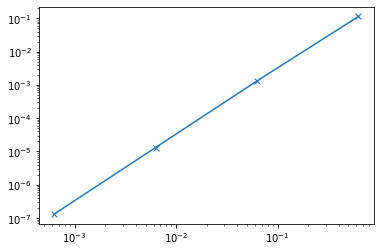

In [24]:
# grid point numbers to try
Ns = 10**np.arange(1, 5)
# create arrays for h and l1
hs = np.zeros(len(Ns))
l1s = np.zeros(len(Ns))
for i, N in enumerate(Ns):
    # now compute h and l1 for each number
    result = get_norms_of_difference(get_second_derivative_v3, N)   #$
    hs[i] = result['h']   #$
    l1s[i] = result['l1']   #$
# do a log-log plot
plt.loglog(hs, l1s, marker='x')

Convergence order of L1 norm: 1.967727e+00 (what value would you expect here?)


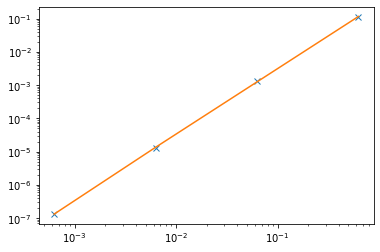

In [25]:
# let's fit a power law function to it
def power_law(h, a, b, c):
    # c is the convergence order
    return a + b * h**c

from scipy.optimize import curve_fit
popt_l1, pcov_l1 = curve_fit(power_law, hs, l1s, sigma=l1s*10)
print("Convergence order of L1 norm: {:e} (what value would you expect here?)".format(popt_l1[2]))

plt.loglog(hs, l1s, 'x')
plt.loglog(hs, power_law(hs, *popt_l1))

Next steps:
* Repeat computing, plotting and fitting a power law to the $L^2$ norm of the error.
* Compute and plot the errors for larger values of $N$. What do you observe? Can you explain the behavior? (tip: think of the operations the program does during the computation)

#### 3. Comparison of  convergence behavior of different expressions
We confirmed with our tests that
$$ f_i'' \approx \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2} $$
indeed converges roughly to second order (i.e. the error is proportional to $h^2$.

We also used the expression
$$ f_i'' \approx \frac{-f_{i-2} + 16f_{i-1} - 30f_i + 16f_{i+1} -f_{i+2}}{12h^2}.$$
Find out the convergence order of this expression by repeating the analysis above.

Convergence order of L1 norm: 3.824754e+00 (what value would you expect here?)


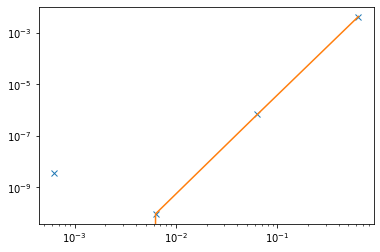

In [26]:
# grid point numbers to try
Ns = 10**np.arange(1, 5)
# create arrays for h and l1   #$
hs = np.zeros(len(Ns))   #$
l1s = np.zeros(len(Ns))   #$
for i, N in enumerate(Ns):   #$
    # now compute h and l1 for each number   #$
    result = get_norms_of_difference(get_second_derivative_v4, N)   #$
    hs[i] = result['h']   #$
    l1s[i] = result['l1']   #$

# let's fit a power law function to it
def power_law(h, a, b, c):   #$
    # c is the convergence order   #$
    return a + b * h**c   #$

from scipy.optimize import curve_fit   #$
popt_l1, pcov_l1 = curve_fit(power_law, hs, l1s, sigma=l1s*10)   #$
print("Convergence order of L1 norm: {:e} (what value would you expect here?)".format(popt_l1[2]))   #$

plt.loglog(hs, l1s, 'x')   #$
plt.loglog(hs, power_law(hs, *popt_l1))   #$

### Determine $\pi$ with random numbers
Goal: combine array operations with boolean indexing

We can determine $\pi$ in a Monte Carlo experiment by drawing pairs of random numbers that correspond to positions on the unit square (i.e. between 0 and 1). Then we can estimate the area of a quarter of the full circle by building the ratio of the number of positions with radius less than one to the total number of positions:
$$ \frac{0.25 \pi r^2}{r^2} \approx \frac{N_{r_i<1}}{N_\text{tot}} $$
This leads to the following approximation for $\pi$:
$$ \pi \approx 4 \frac{N_{r_i<1}}{N_\text{tot}} $$

Let's directly implement it with operations on arrays and compare to a loop version afterwards.

In [27]:
# function for computing pi
def get_pi_montecarlo(number_trials):
    # first generate a random number array of size (number_trials, 2)
    numbers = np.random.rand(number_trials, 2)   #$
    # now compute the radius of each of these positions
    radius = np.sqrt(np.sum(numbers**2, axis=1))   #$
    # create a boolean array to select all radii below 1.0
    in_circle = radius <= 1.0   #$
    # compute the number of points in this circle
    # number_in_circle =
    number_in_circle = in_circle.sum()   #$
    # compute the approximation to pi
    approximate_pi = 4.*number_in_circle/number_trials
    return approximate_pi

print("True value of pi: {:f}".format(np.pi))
# Now print the approximation to pi for different values of trials (e.g. 10**3, 10**4, 10**5)
for N in [10**3, 10**4, 10**5]:   #$
    pi_mc = get_pi_montecarlo(N)   #$
    print("Approximation to pi for {:=d} trials is {:f}.".format(N, pi_mc))   #$

True value of pi: 3.141593
Approximation to pi for 1000 trials is 3.076000.
Approximation to pi for 10000 trials is 3.156400.
Approximation to pi for 100000 trials is 3.141560.


In [28]:
# compute pi with loops
def get_pi_montecarlo_loops(number_trials):
    number_in_circle = 0
    for i in range(number_trials):
        # get random numbers for x and y
        x, y = np.random.rand(2)
        # compute radius
        radius = np.sqrt(x**2 + y**2)
        # is this point in the circle? if yes -> increase the number of points in the circle
        if radius <= 1.0:
            number_in_circle += 1
    # compute the approximation to pi
    approximate_pi = 4.*number_in_circle/number_trials
    return approximate_pi
       
print("True value of pi: {:f}".format(np.pi))
for N in [10**3, 10**4, 10**5]:
    pi_mc_loops = get_pi_montecarlo_loops(N)
    print("Approximation to pi for {:d} trials is {:f}.".format(N, pi_mc_loops))

True value of pi: 3.141593
Approximation to pi for 1000 trials is 3.228000.
Approximation to pi for 10000 trials is 3.165600.
Approximation to pi for 100000 trials is 3.134280.


In [29]:
# compare the timings
N = 10**5
%timeit get_pi_montecarlo(N)
%timeit get_pi_montecarlo_loops(N)

2.84 ms ± 75.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
373 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


For a Monte Carlo experiment like this, it is equivalent to draw 10 numbers at once or do an average over 5 computations with 2 numbers each (you can put other numbers here of course) to get a result with a similar accuracy.

Let's confirm this. Since this is a random number experiment, the errors will change each time you do it, but on average they should be the same.

In [30]:
N1 = 10**3
N2 = 10**5

# do this 3 times
for i in range(3):
    # compute 100 times (i.e. N2/N1=100) pi with N1 numbers
    pi_list = [get_pi_montecarlo(N1) for _ in range(N2//N1)]   #$
    # compute the average of this
    pi1 = np.mean(pi_list)   #$
    # compute pi once with N2 numbers
    pi2 = get_pi_montecarlo(N2)   #$
    # print the values and the relative error to the exact value
    print("Method 1: {:f}, error {:e}".format(pi1, pi1/np.pi-1.0))
    print("Method 2: {:f}, error {:e}".format(pi2, pi2/np.pi-1.0))

Method 1: 3.140760, error -2.650419e-04
Method 2: 3.134280, error -2.327690e-03
Method 1: 3.140320, error -4.050982e-04
Method 2: 3.141480, error -3.585875e-05
Method 1: 3.133960, error -2.429549e-03
Method 2: 3.148160, error 2.090451e-03


The scaling of the error in Monte Carlo methods is expected to be proportional to $1/\sqrt{N}$. Compute pi for different values of $N$, make a log-log-plot of the relative error and plot $1/\sqrt{N}$ in the same graph.

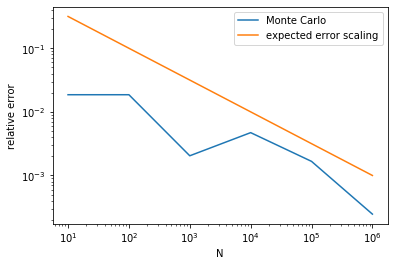

In [31]:
# compute pi for values of N between 10 and 10**7
# Ns =
# pis =
Ns = 10**np.arange(1, 7)   #$
pis = np.array([get_pi_montecarlo(N) for N in Ns])   #$
# compute relative errors (difference to true value of pi divided by pi)
relative_errors = np.abs(pis/np.pi - 1.0)
# plot the relative errors and the expected error in a log-log plot
plt.loglog(Ns, relative_errors, label='Monte Carlo')
plt.loglog(Ns, 1/np.sqrt(Ns), label='expected error scaling')
plt.xlabel("N")
plt.ylabel("relative error")
plt.legend()